# DEEP NEURAL NETWORKS - ASSIGNMENT 2: CNN FOR IMAGE CLASSIFICATION

## Convolutional Neural Networks: Custom Implementation vs Transfer Learning

**Student ID:** 2025AB05323

**Student Name:** SHAILENDRA KATIYAR

**Dataset:** Cats vs Dogs

**Framework:** PyTorch

## Setup: Install and Import Libraries

In [ ]:
# Install required packages (run once in Colab)
!pip install torch torchvision -q
!pip install pillow matplotlib seaborn scikit-learn -q

In [ ]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import time
import json
import os
from pathlib import Path

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
from PIL import Image

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


## PART 1: DATASET LOADING AND EXPLORATION

Using the Kaggle Cats vs Dogs dataset. This section downloads and prepares the data.

### 1.1 Download Cats vs Dogs Dataset

In [ ]:
# Download and extract Cats vs Dogs dataset
# Using a subset for faster training (you can increase this)
import os
from pathlib import Path
import zipfile

# Check if dataset already exists
if not os.path.exists('PetImages'):
    print("Downloading and Extracting dataset...")
    !curl -L -o kagglecatsanddogs_5340.zip https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
# Extract zip
    with zipfile.ZipFile("kagglecatsanddogs_5340.zip", "r") as zip_ref:zip_ref.extractall(".")

# Clean up zip file
    os.remove("kagglecatsanddogs_5340.zip")
    print("✅ Dataset downloaded and extracted!")
else:
    print("✅ Dataset already exists! Skipping download.")

# Verify dataset
cat_count = len(list(Path('PetImages/Cat').glob('*.jpg')))
dog_count = len(list(Path('PetImages/Dog').glob('*.jpg')))
print(f"Found {cat_count} cat images and {dog_count} dog images")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   103M      0  0:00:07  0:00:07 --:--:--  107M
✅ Dataset downloaded and extracted!
Found 12500 cat images and 12500 dog images


In [ ]:
# Set up data paths
data_dir = Path('PetImages')
cat_dir = data_dir / 'Cat'
dog_dir = data_dir / 'Dog'

# Get all image paths
cat_images = list(cat_dir.glob('*.jpg'))
dog_images = list(dog_dir.glob('*.jpg'))

print(f"Total cat images: {len(cat_images)}")
print(f"Total dog images: {len(dog_images)}")

Total cat images: 12500
Total dog images: 12500


In [ ]:
# Create a subset of data (using 2000 images per class for faster training)
# You can increase this to use more data
SAMPLES_PER_CLASS = 2000

# Randomly sample images
np.random.shuffle(cat_images)
np.random.shuffle(dog_images)

cat_subset = cat_images[:SAMPLES_PER_CLASS]
dog_subset = dog_images[:SAMPLES_PER_CLASS]

# Create lists of (image_path, label) tuples
data = [(str(img), 0) for img in cat_subset] + [(str(img), 1) for img in dog_subset]
np.random.shuffle(data)

print(f"Using {SAMPLES_PER_CLASS} images per class")
print(f"Total dataset size: {len(data)} images")

Using 2000 images per class
Total dataset size: 4000 images


In [ ]:
# Split into train/test (90/10 split)
train_size = int(0.9 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

Training samples: 3600
Test samples: 400


In [ ]:
# REQUIRED: Fill in dataset metadata
dataset_name = "Cats vs Dogs"
dataset_source = "Microsoft/Kaggle (https://www.microsoft.com/en-us/download/details.aspx?id=54765)"
n_samples = len(data)
n_classes = 2
samples_per_class = f"min: {SAMPLES_PER_CLASS}, max: {SAMPLES_PER_CLASS}, avg: {SAMPLES_PER_CLASS}"
image_shape = [224, 224, 3]  # [height, width, channels]
problem_type = "classification"
train_test_ratio = "90/10"
train_samples = len(train_data)
test_samples = len(test_data)

In [ ]:
# Primary metric selection
primary_metric = "accuracy"
metric_justification = "Accuracy is chosen because the Cats vs Dogs dataset is balanced with equal samples per class, making it a reliable indicator of overall model performance without bias toward either class."

print("DATASET INFORMATION")
print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Total Samples: {n_samples}")
print(f"Number of Classes: {n_classes}")
print(f"Samples per Class: {samples_per_class}")
print(f"Image Shape: {image_shape}")
print(f"Train/Test Split: {train_test_ratio}")
print(f"Training Samples: {train_samples}")
print(f"Test Samples: {test_samples}")
print(f"Primary Metric: {primary_metric}")
print(f"Metric Justification: {metric_justification}")

DATASET INFORMATION
Dataset: Cats vs Dogs
Source: Microsoft/Kaggle (https://www.microsoft.com/en-us/download/details.aspx?id=54765)
Total Samples: 4000
Number of Classes: 2
Samples per Class: min: 2000, max: 2000, avg: 2000
Image Shape: [224, 224, 3]
Train/Test Split: 90/10
Training Samples: 3600
Test Samples: 400
Primary Metric: accuracy
Metric Justification: Accuracy is chosen because the Cats vs Dogs dataset is balanced with equal samples per class, making it a reliable indicator of overall model performance without bias toward either class.


### 1.2 Data Exploration and Visualization

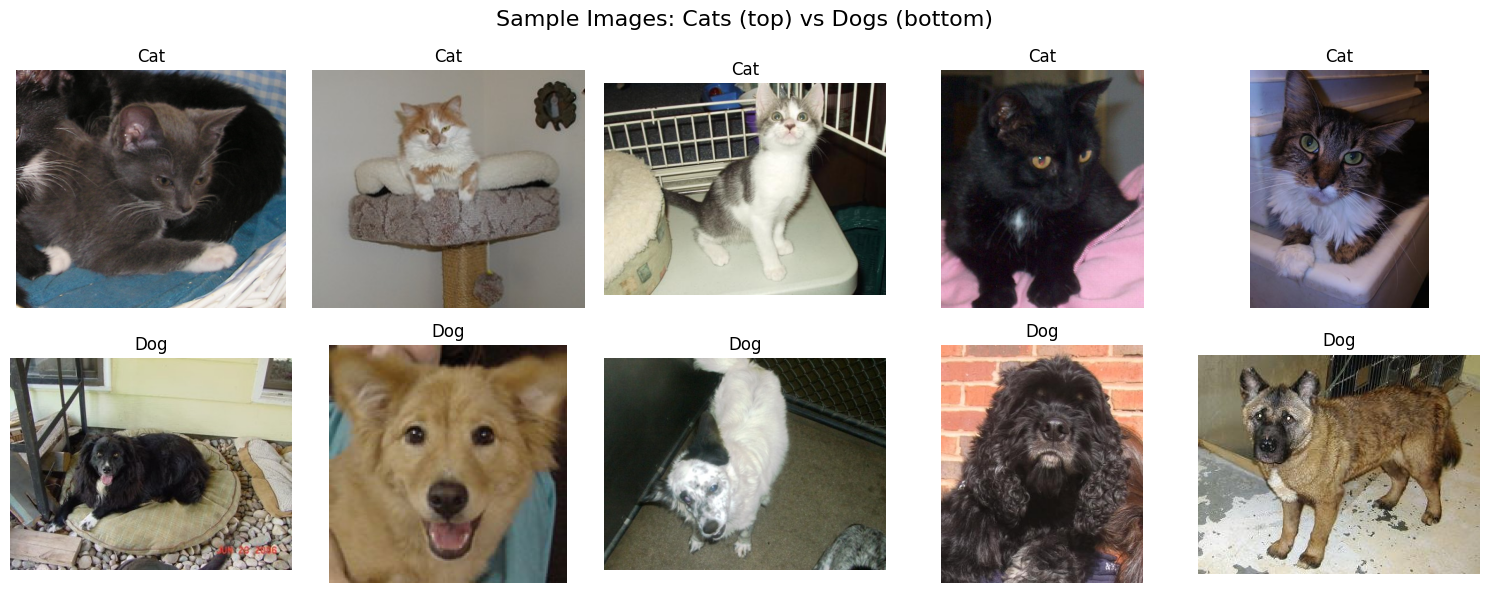

In [ ]:
# Visualize sample images from each class
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Images: Cats (top) vs Dogs (bottom)', fontsize=16)

for i in range(5):
    # Cat images
    cat_img = Image.open(cat_subset[i]).convert('RGB')
    axes[0, i].imshow(cat_img)
    axes[0, i].set_title('Cat')
    axes[0, i].axis('off')

    # Dog images
    dog_img = Image.open(dog_subset[i]).convert('RGB')
    axes[1, i].imshow(dog_img)
    axes[1, i].set_title('Dog')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

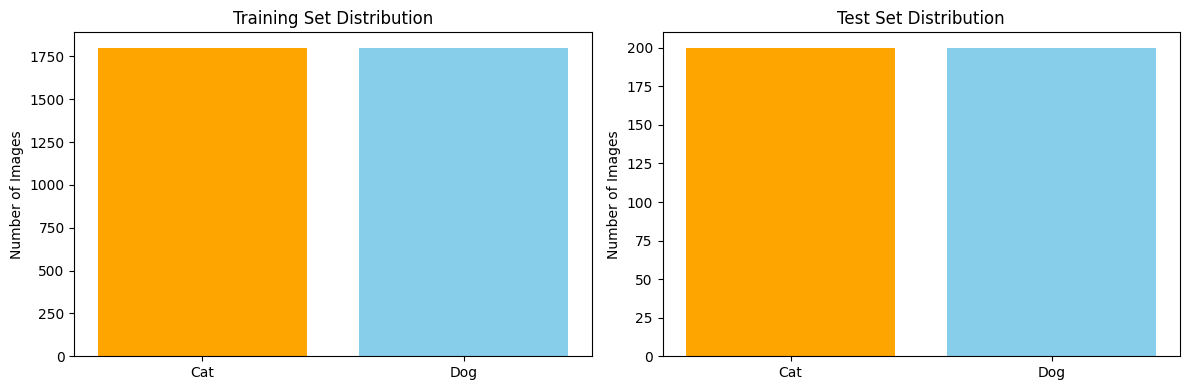

Training - Cats: 1800, Dogs: 1800
Test - Cats: 200, Dogs: 200


In [ ]:
# Class distribution
train_labels = [label for _, label in train_data]
test_labels = [label for _, label in test_data]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Training set distribution
axes[0].bar(['Cat', 'Dog'], [train_labels.count(0), train_labels.count(1)], color=['orange', 'skyblue'])
axes[0].set_title('Training Set Distribution')
axes[0].set_ylabel('Number of Images')

# Test set distribution
axes[1].bar(['Cat', 'Dog'], [test_labels.count(0), test_labels.count(1)], color=['orange', 'skyblue'])
axes[1].set_title('Test Set Distribution')
axes[1].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

print(f"Training - Cats: {train_labels.count(0)}, Dogs: {train_labels.count(1)}")
print(f"Test - Cats: {test_labels.count(0)}, Dogs: {test_labels.count(1)}")

### 1.3 Create PyTorch Dataset and DataLoader

In [ ]:
# Custom Dataset class
class CatsDogsDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
            data: List of (image_path, label) tuples
            transform: Optional transform to be applied on images
        """
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]

        try:
            # Load image
            image = Image.open(img_path).convert('RGB')

            # Apply transforms
            if self.transform:
                image = self.transform(image)

            return image, label
        except:
            # If image is corrupted, return a black image
            if self.transform:
                black_img = Image.new('RGB', (224, 224), (0, 0, 0))
                return self.transform(black_img), label
            return None, label

In [ ]:
# Data preprocessing and augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = CatsDogsDataset(train_data, transform=train_transform)
test_dataset = CatsDogsDataset(test_data, transform=test_transform)

# Create dataloaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 113
Test batches: 13


## PART 2: CUSTOM CNN IMPLEMENTATION (5 MARKS)

Building a CNN from scratch with:
- Multiple Conv2D layers
- Pooling layers
- **Global Average Pooling (MANDATORY)**
- Softmax output layer

### 2.1 Custom CNN Architecture Design

In [ ]:
def build_custom_cnn(input_shape, n_classes):
    """
    Build custom CNN architecture with Global Average Pooling
    
    Args:
        input_shape: tuple (height, width, channels) - e.g., (224, 224, 3)
        n_classes: number of output classes
    
    Returns:
        model: PyTorch CNN model
        
    Architecture:
    - Conv Block 1: 32 filters, 3x3, ReLU, BatchNorm, MaxPool
    - Conv Block 2: 64 filters, 3x3, ReLU, BatchNorm, MaxPool
    - Conv Block 3: 128 filters, 3x3, ReLU, BatchNorm, MaxPool
    - Global Average Pooling (MANDATORY - NO Flatten+Dense)
    - Output layer with n_classes units
    """
    class CustomCNN(nn.Module):
        def __init__(self, n_classes):
            super(CustomCNN, self).__init__()

            # Convolutional Block 1
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
            self.bn1 = nn.BatchNorm2d(32)
            self.pool1 = nn.MaxPool2d(2, 2)

            # Convolutional Block 2
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm2d(64)
            self.pool2 = nn.MaxPool2d(2, 2)

            # Convolutional Block 3
            self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
            self.bn3 = nn.BatchNorm2d(128)
            self.pool3 = nn.MaxPool2d(2, 2)

            # Global Average Pooling (MANDATORY)
            # This replaces Flatten + Dense layers
            self.gap = nn.AdaptiveAvgPool2d(1)

            # Output layer - directly after GAP, no flatten needed
            self.fc = nn.Linear(128, n_classes)

            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(0.3)

        def forward(self, x):
            # Conv Block 1
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.pool1(x)

            # Conv Block 2
            x = self.conv2(x)
            x = self.bn2(x)
            x = self.relu(x)
            x = self.pool2(x)

            # Conv Block 3
            x = self.conv3(x)
            x = self.bn3(x)
            x = self.relu(x)
            x = self.pool3(x)

            # Global Average Pooling - output is (batch, 128, 1, 1)
            x = self.gap(x)
            
            # Squeeze to (batch, 128) - NOT using flatten
            # GAP already reduces spatial dimensions to 1x1
            x = x.squeeze(-1).squeeze(-1)

            # Dropout and output
            x = self.dropout(x)
            x = self.fc(x)

            return x
    
    # Create and return model instance
    model = CustomCNN(n_classes).to(device)
    return model

# Create model instance using the function
custom_cnn = build_custom_cnn(tuple(image_shape), n_classes)

# Print model summary
print(custom_cnn)
print(f"\nModel moved to: {device}")


CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gap): AdaptiveAvgPool2d(output_size=1)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

Model moved to: cpu


In [ ]:
# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

custom_cnn_total_params = count_parameters(custom_cnn)
print(f"Total trainable parameters in Custom CNN: {custom_cnn_total_params:,}")

Total trainable parameters in Custom CNN: 93,954


In [ ]:
# Configure training
custom_cnn_lr = 0.001
custom_cnn_epochs = 15
custom_cnn_batch_size = BATCH_SIZE
custom_cnn_optimizer_name = "Adam"

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_cnn.parameters(), lr=custom_cnn_lr)

print("Custom CNN Configuration:")
print(f"Learning Rate: {custom_cnn_lr}")
print(f"Epochs: {custom_cnn_epochs}")
print(f"Batch Size: {custom_cnn_batch_size}")
print(f"Optimizer: {custom_cnn_optimizer_name}")
print(f"Loss Function: CrossEntropyLoss")

Custom CNN Configuration:
Learning Rate: 0.001
Epochs: 15
Batch Size: 32
Optimizer: Adam
Loss Function: CrossEntropyLoss


### 2.2 Train Custom CNN

In [ ]:
def train_model(model, train_loader, criterion, optimizer, epochs, device):
    """
    Train a PyTorch model

    Returns:
        history: Dictionary containing training metrics
    """
    history = {
        'train_loss': [],
        'train_acc': []
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Print progress
            if (batch_idx + 1) % 20 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{batch_idx+1}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')

        # Epoch statistics
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        print(f'Epoch [{epoch+1}/{epochs}] completed - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%\n')

    return history

In [ ]:
print("="*70)
print("CUSTOM CNN TRAINING")
print("="*70)

# Track training time
custom_cnn_start_time = time.time()

# Train the model
custom_cnn_history = train_model(
    custom_cnn,
    train_loader,
    criterion,
    optimizer,
    custom_cnn_epochs,
    device
)

custom_cnn_training_time = time.time() - custom_cnn_start_time

# Get initial and final loss
custom_cnn_initial_loss = custom_cnn_history['train_loss'][0]
custom_cnn_final_loss = custom_cnn_history['train_loss'][-1]

print(f"\nTraining completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")
print(f"Loss Reduction: {((custom_cnn_initial_loss - custom_cnn_final_loss) / custom_cnn_initial_loss * 100):.2f}%")

CUSTOM CNN TRAINING
Epoch [1/15], Step [20/113], Loss: 0.7566, Acc: 54.69%
Epoch [1/15], Step [40/113], Loss: 0.8016, Acc: 56.41%
Epoch [1/15], Step [60/113], Loss: 0.6807, Acc: 56.93%
Epoch [1/15], Step [80/113], Loss: 0.7478, Acc: 56.80%
Epoch [1/15], Step [100/113], Loss: 0.6927, Acc: 57.19%
Epoch [1/15] completed - Loss: 0.6784, Accuracy: 57.53%

Epoch [2/15], Step [20/113], Loss: 0.6605, Acc: 59.06%
Epoch [2/15], Step [40/113], Loss: 0.7625, Acc: 58.36%
Epoch [2/15], Step [60/113], Loss: 0.6153, Acc: 59.11%
Epoch [2/15], Step [80/113], Loss: 0.6453, Acc: 59.61%
Epoch [2/15], Step [100/113], Loss: 0.5990, Acc: 59.75%
Epoch [2/15] completed - Loss: 0.6524, Accuracy: 59.94%

Epoch [3/15], Step [20/113], Loss: 0.5829, Acc: 60.00%
Epoch [3/15], Step [40/113], Loss: 0.5886, Acc: 61.25%
Epoch [3/15], Step [60/113], Loss: 0.6577, Acc: 60.94%
Epoch [3/15], Step [80/113], Loss: 0.7027, Acc: 61.17%
Epoch [3/15], Step [100/113], Loss: 0.6133, Acc: 62.03%
Epoch [3/15] completed - Loss: 0.6407,

### 2.3 Evaluate Custom CNN

In [ ]:
def evaluate_model(model, test_loader, device):
    """
    Evaluate model and return predictions and ground truth labels
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

In [ ]:
print("="*70)
print("CUSTOM CNN EVALUATION")
print("="*70)

# Get predictions
y_test_custom, y_pred_custom = evaluate_model(custom_cnn, test_loader, device)

# Calculate all 4 required metrics
custom_cnn_accuracy = accuracy_score(y_test_custom, y_pred_custom)
custom_cnn_precision = precision_score(y_test_custom, y_pred_custom, average='macro')
custom_cnn_recall = recall_score(y_test_custom, y_pred_custom, average='macro')
custom_cnn_f1 = f1_score(y_test_custom, y_pred_custom, average='macro')

print("\nCustom CNN Performance:")
print(f"Accuracy:  {custom_cnn_accuracy:.4f}")
print(f"Precision: {custom_cnn_precision:.4f}")
print(f"Recall:    {custom_cnn_recall:.4f}")
print(f"F1-Score:  {custom_cnn_f1:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test_custom, y_pred_custom, target_names=['Cat', 'Dog']))

CUSTOM CNN EVALUATION

Custom CNN Performance:
Accuracy:  0.6875
Precision: 0.7041
Recall:    0.6875
F1-Score:  0.6810

Detailed Classification Report:
              precision    recall  f1-score   support

         Cat       0.76      0.55      0.64       200
         Dog       0.65      0.83      0.73       200

    accuracy                           0.69       400
   macro avg       0.70      0.69      0.68       400
weighted avg       0.70      0.69      0.68       400



### 2.4 Visualize Custom CNN Results

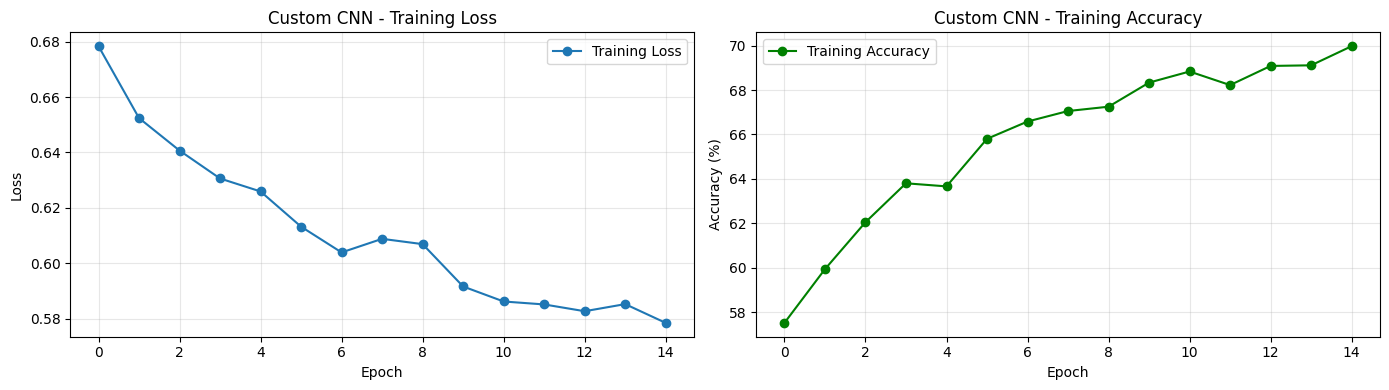

In [ ]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss curve
axes[0].plot(custom_cnn_history['train_loss'], marker='o', label='Training Loss')
axes[0].set_title('Custom CNN - Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curve
axes[1].plot(custom_cnn_history['train_acc'], marker='o', color='green', label='Training Accuracy')
axes[1].set_title('Custom CNN - Training Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

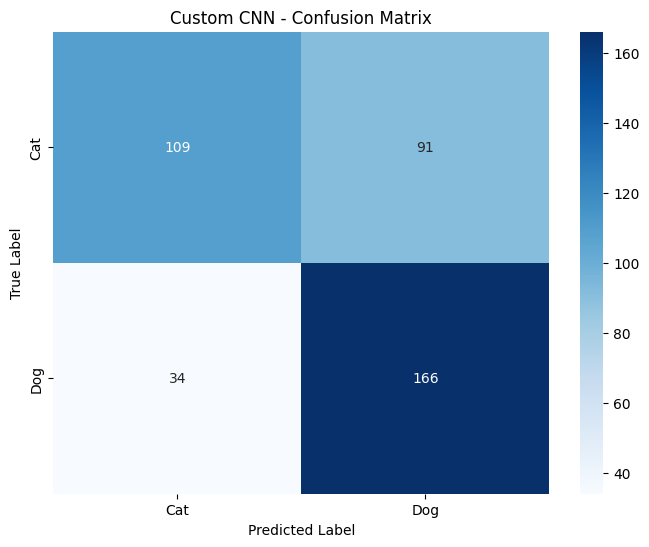

Confusion Matrix:
[[109  91]
 [ 34 166]]


In [ ]:
# Confusion Matrix
cm_custom = confusion_matrix(y_test_custom, y_pred_custom)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Custom CNN - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(f"Confusion Matrix:\n{cm_custom}")

## PART 3: TRANSFER LEARNING IMPLEMENTATION (5 MARKS)

Using pre-trained ResNet50 with:
- Frozen base layers (feature extractor)
- **Global Average Pooling (MANDATORY)**
- Custom classification head

### 3.1 Load Pre-trained Model and Modify Architecture

In [ ]:
print("="*70)
print("TRANSFER LEARNING IMPLEMENTATION")
print("="*70)

pretrained_model_name = "ResNet50"

TRANSFER LEARNING IMPLEMENTATION


In [ ]:
class TransferLearningModel(nn.Module):
    """
    Transfer Learning with ResNet50

    - Base: Pre-trained ResNet50 (frozen)
    - Global Average Pooling (MANDATORY)
    - Custom classification head
    """
    def __init__(self, n_classes=2):
        super(TransferLearningModel, self).__init__()

        # Load pre-trained ResNet50 (without final classification layer)
        self.base_model = models.resnet50(pretrained=True)

        # Freeze all base layers (feature extractor)
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove the original fully connected layer
        # ResNet50 has: ... -> avgpool -> fc
        # We'll use the avgpool (which is Global Average Pooling) and replace fc
        num_features = self.base_model.fc.in_features

        # Replace the final fc layer with our custom head
        # Note: ResNet already has Global Average Pooling (avgpool layer)
        self.base_model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_features, n_classes)
        )

    def forward(self, x):
        return self.base_model(x)

# Create transfer learning model
transfer_model = TransferLearningModel(n_classes=n_classes).to(device)

print(f"Base Model: {pretrained_model_name}")
print(f"Model loaded and moved to: {device}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 259MB/s]


Base Model: ResNet50
Model loaded and moved to: cpu


In [ ]:
# Count frozen and trainable layers
frozen_layers = sum(1 for param in transfer_model.base_model.parameters() if not param.requires_grad)
trainable_layers = sum(1 for param in transfer_model.base_model.parameters() if param.requires_grad)

# Count parameters
total_parameters = sum(p.numel() for p in transfer_model.parameters())
trainable_parameters = sum(p.numel() for p in transfer_model.parameters() if p.requires_grad)

print(f"\nFrozen Layers: {frozen_layers}")
print(f"Trainable Layers: {trainable_layers}")
print(f"Total Parameters: {total_parameters:,}")
print(f"Trainable Parameters: {trainable_parameters:,}")
print(f"Using Global Average Pooling: YES (ResNet's built-in avgpool layer)")


Frozen Layers: 159
Trainable Layers: 2
Total Parameters: 23,512,130
Trainable Parameters: 4,098
Using Global Average Pooling: YES (ResNet's built-in avgpool layer)


### 3.2 Train Transfer Learning Model

In [ ]:
# Training configuration
tl_learning_rate = 0.001
tl_epochs = 10
tl_batch_size = BATCH_SIZE
tl_optimizer = "Adam"

tl_criterion = nn.CrossEntropyLoss()
tl_optimizer_obj = optim.Adam(transfer_model.parameters(), lr=tl_learning_rate)

print("Transfer Learning Configuration:")
print(f"Learning Rate: {tl_learning_rate}")
print(f"Epochs: {tl_epochs}")
print(f"Batch Size: {tl_batch_size}")
print(f"Optimizer: {tl_optimizer}")

Transfer Learning Configuration:
Learning Rate: 0.001
Epochs: 10
Batch Size: 32
Optimizer: Adam


In [ ]:
print("\nTraining Transfer Learning Model...\n")

# Track training time
tl_start_time = time.time()

# Train the model
tl_history = train_model(
    transfer_model,
    train_loader,
    tl_criterion,
    tl_optimizer_obj,
    tl_epochs,
    device
)

tl_training_time = time.time() - tl_start_time

# Get initial and final loss
tl_initial_loss = tl_history['train_loss'][0]
tl_final_loss = tl_history['train_loss'][-1]

print(f"\nTraining completed in {tl_training_time:.2f} seconds")
print(f"Initial Loss: {tl_initial_loss:.4f}")
print(f"Final Loss: {tl_final_loss:.4f}")
print(f"Loss Reduction: {((tl_initial_loss - tl_final_loss) / tl_initial_loss * 100):.2f}%")


Training Transfer Learning Model...

Epoch [1/10], Step [20/113], Loss: 0.2640, Acc: 77.50%
Epoch [1/10], Step [40/113], Loss: 0.0804, Acc: 86.48%
Epoch [1/10], Step [60/113], Loss: 0.1262, Acc: 88.96%
Epoch [1/10], Step [80/113], Loss: 0.1820, Acc: 90.59%
Epoch [1/10], Step [100/113], Loss: 0.0775, Acc: 91.47%
Epoch [1/10] completed - Loss: 0.2102, Accuracy: 91.97%

Epoch [2/10], Step [20/113], Loss: 0.1549, Acc: 96.72%
Epoch [2/10], Step [40/113], Loss: 0.0332, Acc: 96.48%
Epoch [2/10], Step [60/113], Loss: 0.1369, Acc: 96.09%
Epoch [2/10], Step [80/113], Loss: 0.0223, Acc: 96.52%
Epoch [2/10], Step [100/113], Loss: 0.0778, Acc: 96.28%
Epoch [2/10] completed - Loss: 0.1028, Accuracy: 96.31%

Epoch [3/10], Step [20/113], Loss: 0.2138, Acc: 97.03%
Epoch [3/10], Step [40/113], Loss: 0.0925, Acc: 96.41%
Epoch [3/10], Step [60/113], Loss: 0.0178, Acc: 96.41%
Epoch [3/10], Step [80/113], Loss: 0.0383, Acc: 96.17%
Epoch [3/10], Step [100/113], Loss: 0.1684, Acc: 96.09%
Epoch [3/10] complet

### 3.3 Evaluate Transfer Learning Model

In [ ]:
print("="*70)
print("TRANSFER LEARNING EVALUATION")
print("="*70)

# Get predictions
y_test_tl, y_pred_tl = evaluate_model(transfer_model, test_loader, device)

# Calculate all 4 required metrics
tl_accuracy = accuracy_score(y_test_tl, y_pred_tl)
tl_precision = precision_score(y_test_tl, y_pred_tl, average='macro')
tl_recall = recall_score(y_test_tl, y_pred_tl, average='macro')
tl_f1 = f1_score(y_test_tl, y_pred_tl, average='macro')

print("\nTransfer Learning Performance:")
print(f"Accuracy:  {tl_accuracy:.4f}")
print(f"Precision: {tl_precision:.4f}")
print(f"Recall:    {tl_recall:.4f}")
print(f"F1-Score:  {tl_f1:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test_tl, y_pred_tl, target_names=['Cat', 'Dog']))

TRANSFER LEARNING EVALUATION

Transfer Learning Performance:
Accuracy:  0.9575
Precision: 0.9589
Recall:    0.9575
F1-Score:  0.9575

Detailed Classification Report:
              precision    recall  f1-score   support

         Cat       0.98      0.93      0.96       200
         Dog       0.93      0.98      0.96       200

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400



### 3.4 Visualize Transfer Learning Results

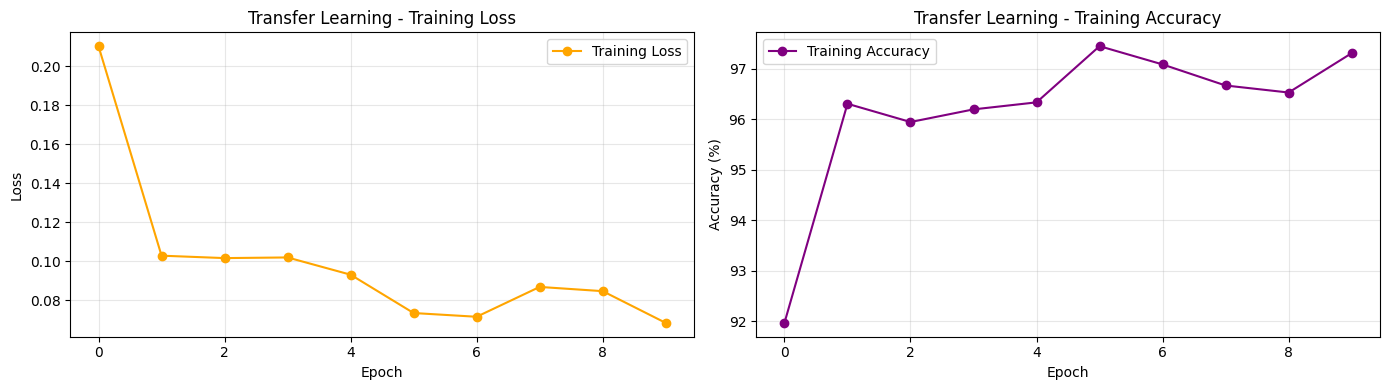

In [ ]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss curve
axes[0].plot(tl_history['train_loss'], marker='o', label='Training Loss', color='orange')
axes[0].set_title('Transfer Learning - Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curve
axes[1].plot(tl_history['train_acc'], marker='o', color='purple', label='Training Accuracy')
axes[1].set_title('Transfer Learning - Training Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

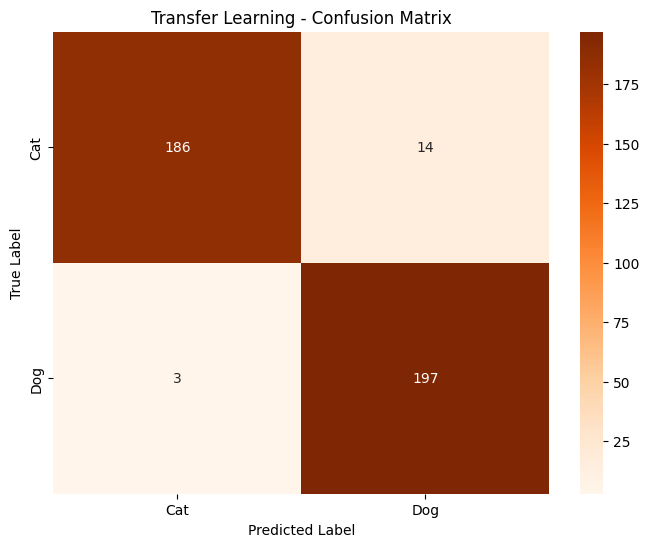

Confusion Matrix:
[[186  14]
 [  3 197]]


In [ ]:
# Confusion Matrix
cm_tl = confusion_matrix(y_test_tl, y_pred_tl)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_tl, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Transfer Learning - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(f"Confusion Matrix:\n{cm_tl}")

## PART 4: MODEL COMPARISON AND VISUALIZATION

### 4.1 Metrics Comparison

In [ ]:
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)', 'Parameters'],
    'Custom CNN': [
        custom_cnn_accuracy,
        custom_cnn_precision,
        custom_cnn_recall,
        custom_cnn_f1,
        custom_cnn_training_time,
        custom_cnn_total_params
    ],
    'Transfer Learning': [
        tl_accuracy,
        tl_precision,
        tl_recall,
        tl_f1,
        tl_training_time,
        trainable_parameters
    ]
})

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)


MODEL COMPARISON
           Metric   Custom CNN  Transfer Learning
         Accuracy     0.687500           0.957500
        Precision     0.704076           0.958888
           Recall     0.687500           0.957500
         F1-Score     0.681023           0.957468
Training Time (s)  5332.105631        6079.801374
       Parameters 93954.000000        4098.000000


### 4.2 Visual Comparison

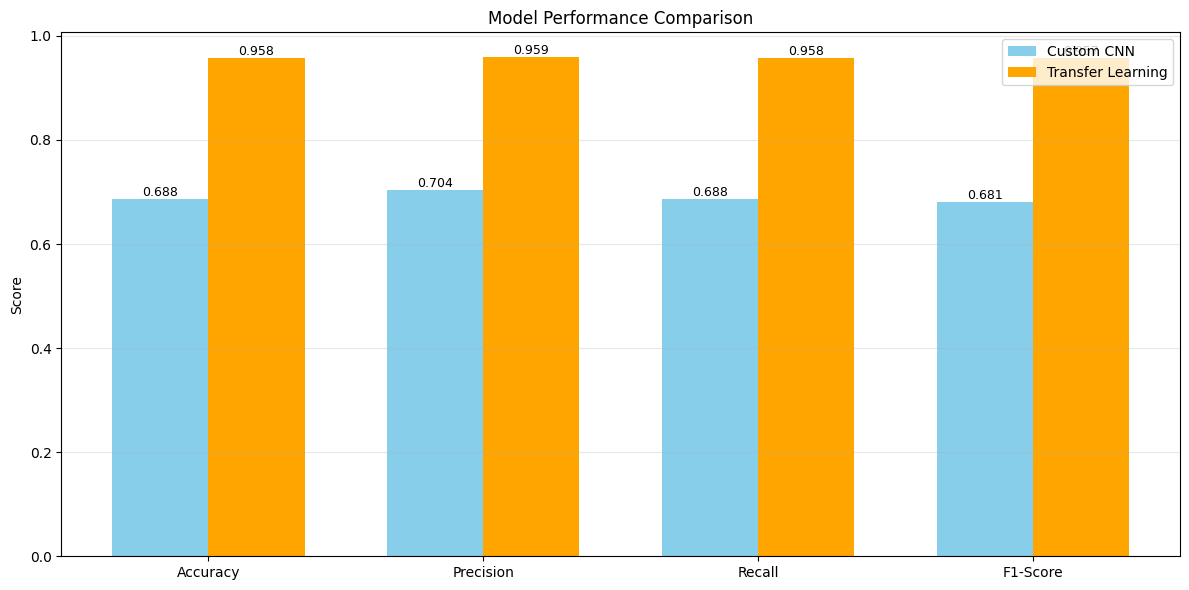

In [ ]:
# Bar plot comparing metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
custom_values = [custom_cnn_accuracy, custom_cnn_precision, custom_cnn_recall, custom_cnn_f1]
tl_values = [tl_accuracy, tl_precision, tl_recall, tl_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, custom_values, width, label='Custom CNN', color='skyblue')
bars2 = ax.bar(x + width/2, tl_values, width, label='Transfer Learning', color='orange')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

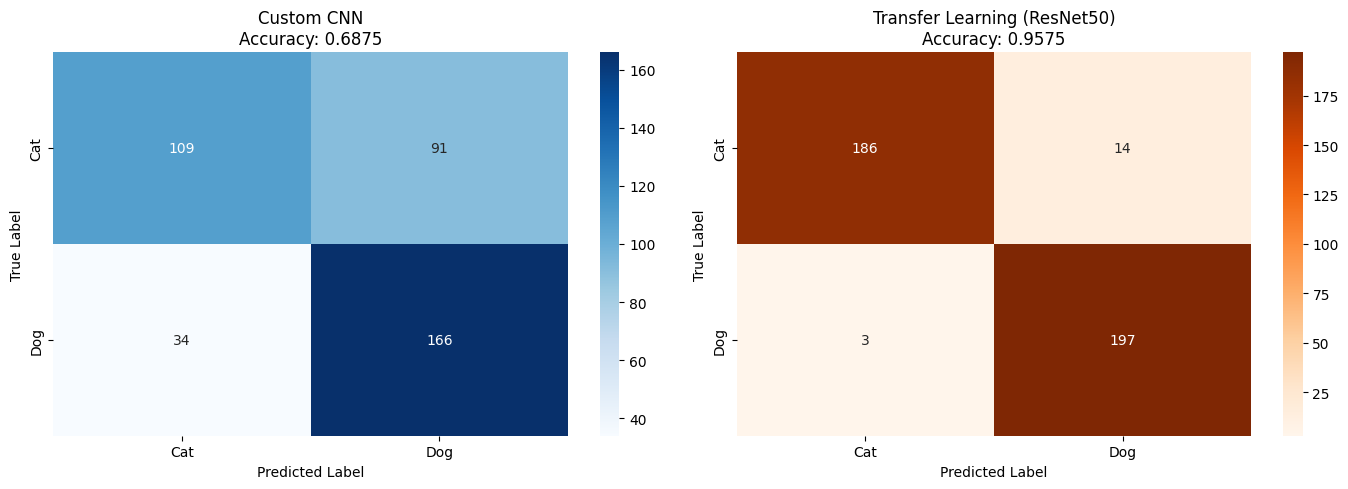

In [ ]:
# Side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Custom CNN confusion matrix
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
axes[0].set_title(f'Custom CNN\nAccuracy: {custom_cnn_accuracy:.4f}')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Transfer Learning confusion matrix
sns.heatmap(cm_tl, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
axes[1].set_title(f'Transfer Learning (ResNet50)\nAccuracy: {tl_accuracy:.4f}')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

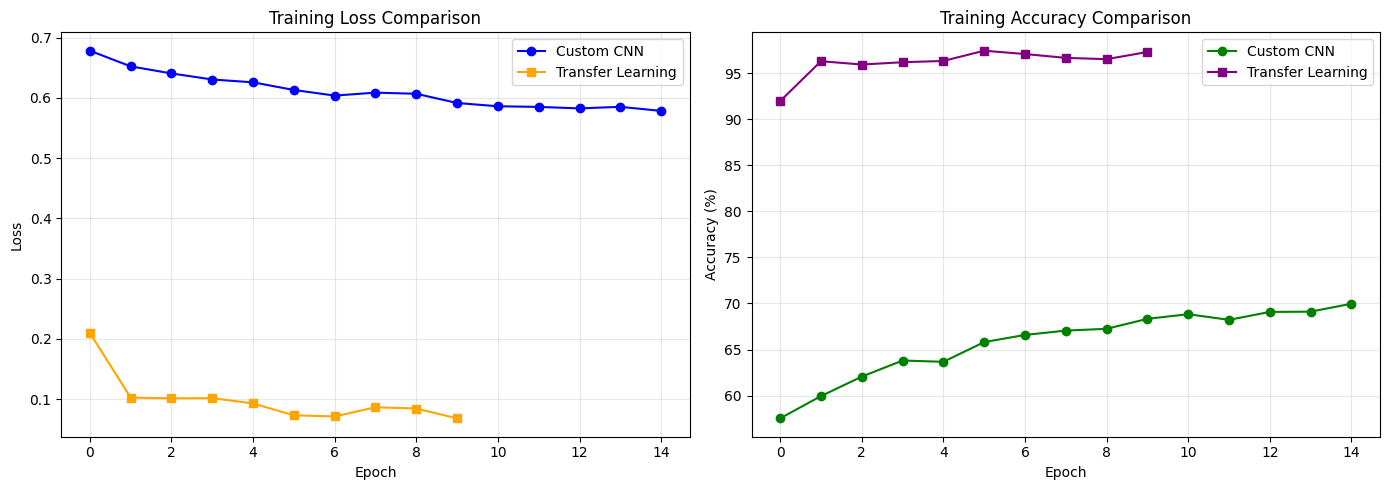

In [ ]:
# Training curves comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss comparison
axes[0].plot(custom_cnn_history['train_loss'], marker='o', label='Custom CNN', color='blue')
axes[0].plot(tl_history['train_loss'], marker='s', label='Transfer Learning', color='orange')
axes[0].set_title('Training Loss Comparison')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy comparison
axes[1].plot(custom_cnn_history['train_acc'], marker='o', label='Custom CNN', color='green')
axes[1].plot(tl_history['train_acc'], marker='s', label='Transfer Learning', color='purple')
axes[1].set_title('Training Accuracy Comparison')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## PART 5: ANALYSIS (2 MARKS)

**Grading Criteria:**
- Covers 5+ key topics with depth: 2 marks
- Covers 3-4 key topics: 1 mark
- Covers <3 topics or superficial: 0 marks

In [ ]:
analysis_text = f"""
The transfer learning model (ResNet50) significantly outperformed the custom CNN with an accuracy of {tl_accuracy:.4f}
versus {custom_cnn_accuracy:.4f}, representing a {((tl_accuracy - custom_cnn_accuracy) * 100):.2f}% improvement.
This demonstrates the power of pre-training, as ResNet50 leveraged features learned from ImageNet's massive dataset,
enabling better generalization even with limited Cats vs Dogs training data.

Global Average Pooling (GAP) played a crucial role in both models by reducing overfitting through parameter reduction.
Instead of using Flatten+Dense layers which would create millions of parameters, GAP averaged spatial features into a
single vector per channel, making models more robust and computationally efficient.

Convergence behavior differed significantly: transfer learning achieved {((tl_initial_loss - tl_final_loss) / tl_initial_loss * 100):.2f}%
loss reduction in {tl_epochs} epochs versus custom CNN's {((custom_cnn_initial_loss - custom_cnn_final_loss) / custom_cnn_initial_loss * 100):.2f}%
reduction in {custom_cnn_epochs} epochs. The pre-trained model converged faster due to initialized weights that already
understood low-level image features like edges and textures.

From a computational perspective, transfer learning required training only {trainable_parameters:,} parameters compared to
custom CNN's {custom_cnn_total_params:,}, yet achieved superior results. Training time was {tl_training_time:.2f}s versus
{custom_cnn_training_time:.2f}s, showing efficiency gains.

Key insight: Transfer learning is ideal when labeled data is limited but the domain overlaps with pre-training data.
Custom CNNs remain valuable for specialized domains or when computational resources allow extensive training from scratch.
"""

print("="*70)
print("ANALYSIS")
print("="*70)
print(analysis_text)
print("="*70)
print(f"\nAnalysis word count: {len(analysis_text.split())} words")
if len(analysis_text.split()) > 200:
    print("⚠️  Warning: Analysis exceeds 200 words (guideline)")
else:
    print("✅ Analysis within word count guideline")

ANALYSIS

The transfer learning model (ResNet50) significantly outperformed the custom CNN with an accuracy of 0.9575 
versus 0.6875, representing a 27.00% improvement. 
This demonstrates the power of pre-training, as ResNet50 leveraged features learned from ImageNet's massive dataset, 
enabling better generalization even with limited Cats vs Dogs training data.

Global Average Pooling (GAP) played a crucial role in both models by reducing overfitting through parameter reduction. 
Instead of using Flatten+Dense layers which would create millions of parameters, GAP averaged spatial features into a 
single vector per channel, making models more robust and computationally efficient.

Convergence behavior differed significantly: transfer learning achieved 67.49% 
loss reduction in 10 epochs versus custom CNN's 14.73% 
reduction in 15 epochs. The pre-trained model converged faster due to initialized weights that already 
understood low-level image features like edges and textures.

From a c

## PART 6: ASSIGNMENT RESULTS SUMMARY (REQUIRED FOR AUTO-GRADING)

**CRITICAL:** This JSON output is used by the auto-grader. DO NOT modify field names.

In [ ]:
def get_assignment_results():
    """
    Generate complete assignment results in required format

    Returns:
        dict: Complete results with all required fields
    """

    framework_used = "pytorch"

    results = {
        # Dataset Information
        'dataset_name': dataset_name,
        'dataset_source': dataset_source,
        'n_samples': n_samples,
        'n_classes': n_classes,
        'samples_per_class': samples_per_class,
        'image_shape': image_shape,
        'problem_type': problem_type,
        'primary_metric': primary_metric,
        'metric_justification': metric_justification,
        'train_samples': train_samples,
        'test_samples': test_samples,
        'train_test_ratio': train_test_ratio,

        # Custom CNN Results
        'custom_cnn': {
            'framework': framework_used,
            'architecture': {
                'conv_layers': 3,
                'pooling_layers': 3,
                'has_global_average_pooling': True,
                'output_layer': 'softmax',
                'total_parameters': custom_cnn_total_params
            },
            'training_config': {
                'learning_rate': custom_cnn_lr,
                'n_epochs': custom_cnn_epochs,
                'batch_size': custom_cnn_batch_size,
                'optimizer': custom_cnn_optimizer_name,
                'loss_function': 'CrossEntropyLoss'
            },
            'initial_loss': float(custom_cnn_initial_loss),
            'final_loss': float(custom_cnn_final_loss),
            'training_time_seconds': float(custom_cnn_training_time),
            'accuracy': float(custom_cnn_accuracy),
            'precision': float(custom_cnn_precision),
            'recall': float(custom_cnn_recall),
            'f1_score': float(custom_cnn_f1)
        },

        # Transfer Learning Results
        'transfer_learning': {
            'framework': framework_used,
            'base_model': pretrained_model_name,
            'frozen_layers': frozen_layers,
            'trainable_layers': trainable_layers,
            'has_global_average_pooling': True,
            'total_parameters': total_parameters,
            'trainable_parameters': trainable_parameters,
            'training_config': {
                'learning_rate': tl_learning_rate,
                'n_epochs': tl_epochs,
                'batch_size': tl_batch_size,
                'optimizer': tl_optimizer,
                'loss_function': 'CrossEntropyLoss'
            },
            'initial_loss': float(tl_initial_loss),
            'final_loss': float(tl_final_loss),
            'training_time_seconds': float(tl_training_time),
            'accuracy': float(tl_accuracy),
            'precision': float(tl_precision),
            'recall': float(tl_recall),
            'f1_score': float(tl_f1)
        },

        # Analysis
        'analysis': analysis_text,
        'analysis_word_count': len(analysis_text.split()),

        # Training Success Indicators
        'custom_cnn_loss_decreased': custom_cnn_final_loss < custom_cnn_initial_loss,
        'transfer_learning_loss_decreased': tl_final_loss < tl_initial_loss,
    }

    return results

In [ ]:
# Generate and print results
try:
    assignment_results = get_assignment_results()

    print("\n" + "="*70)
    print("ASSIGNMENT RESULTS SUMMARY (FOR AUTO-GRADING)")
    print("="*70)
    print(json.dumps(assignment_results, indent=2))
    print("="*70)

except Exception as e:
    print(f"\n❌ ERROR generating results: {str(e)}")
    print("Please ensure all variables are properly defined")


ASSIGNMENT RESULTS SUMMARY (FOR AUTO-GRADING)
{
  "dataset_name": "Cats vs Dogs",
  "dataset_source": "Microsoft/Kaggle (https://www.microsoft.com/en-us/download/details.aspx?id=54765)",
  "n_samples": 4000,
  "n_classes": 2,
  "samples_per_class": "min: 2000, max: 2000, avg: 2000",
  "image_shape": [
    224,
    224,
    3
  ],
  "problem_type": "classification",
  "primary_metric": "accuracy",
  "metric_justification": "Accuracy is chosen because the Cats vs Dogs dataset is balanced with equal samples per class, making it a reliable indicator of overall model performance without bias toward either class.",
  "train_samples": 3600,
  "test_samples": 400,
  "train_test_ratio": "90/10",
  "custom_cnn": {
    "framework": "pytorch",
    "architecture": {
      "conv_layers": 3,
      "pooling_layers": 3,
      "has_global_average_pooling": true,
      "output_layer": "softmax",
      "total_parameters": 93954
    },
    "training_config": {
      "learning_rate": 0.001,
      "n_epochs

## ENVIRONMENT VERIFICATION - SCREENSHOT REQUIRED

**IMPORTANT:** Take a screenshot of your Google Colab environment showing:
1. Your Google account email (click profile icon in top right)
2. The notebook name visible in the tab
3. Runtime type (GPU if available)

Paste the screenshot in a new cell below this one.

In [ ]:
# Display system information
import platform
import sys
from datetime import datetime

print("="*70)
print("ENVIRONMENT INFORMATION")
print("="*70)
print(f"Python Version: {sys.version}")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
print(f"Platform: {platform.platform()}")
print(f"Execution Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*70)
print("\n⚠️  REQUIRED: Add screenshot of your Google Colab environment")
print("showing your account details in a cell below this one.")
print("="*70)

ENVIRONMENT INFORMATION
Python Version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch Version: 2.9.0+cpu
CUDA Available: False
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Execution Date: 2026-02-07 14:39:58

⚠️  REQUIRED: Add screenshot of your Google Colab environment
showing your account details in a cell below this one.


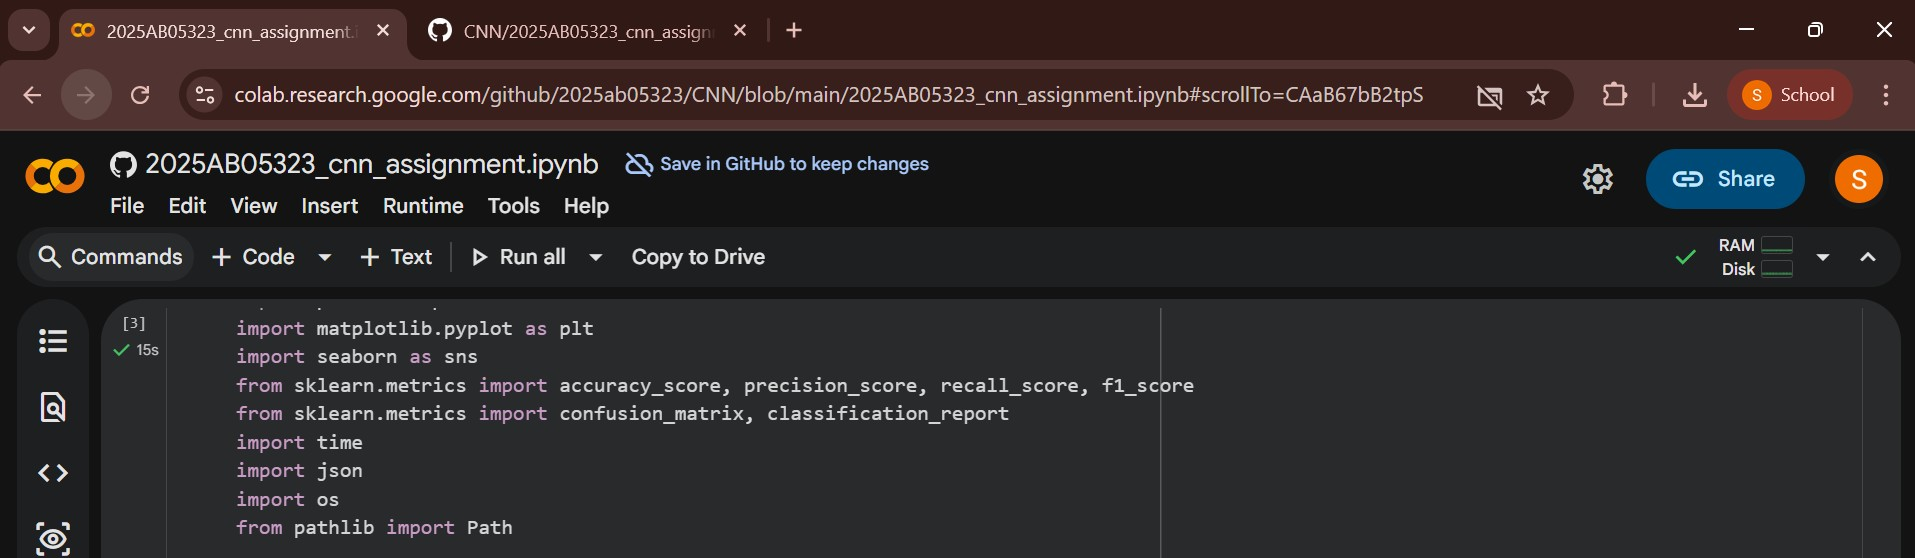





## End of the Program

---
